In [2]:
# Imports
%matplotlib notebook
# numpy, matplotlib, seaborn and matplotlib
import matplotlib
from bigfloat import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import special
from sklearn.linear_model import LogisticRegression
# missing data visualization library
import missingno as msno
sns.set_style('whitegrid')
# define data path
INPUT_PATH = "../data/%s.csv"
# define small samples to quickly explore data
read_rows = 300;

In [3]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn import preprocessing
from pylightgbm.models import GBMClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import metrics, grid_search
from time import time

# Dataset Visualization Part

## Overview Part
This part is to overview the first N rows of the sample to get initial feeling of the dataset

In [ ]:
# load data head for overview
train_date_overview = pd.read_csv('../data/train_date.csv',nrows = read_rows)
#train_categorical_overview = pd.read_csv('../data/train_categorical.csv',nrows = read_rows)
#train_numeric_overview = pd.read_csv('../data/train_numeric.csv',nrows = read_rows)
#test_categorical_overview = pd.read_csv('../data/test_categorical.csv', nrows = read_rows)
#test_date_overview = pd.read_csv('../data/test_date.csv', nrows = read_rows)
#test_numeric_overview = pd.read_csv('../data/test_numeric.csv', nrows = read_rows)

In [ ]:
#train_numeric_overview
#train_categorical_overview
#train_date_overview
#test_numeric_overview
#test_categorical_overview
#test_date_overview 

## General Feature Exploration Part
This part is to explore the common feature

In [ ]:
# function to calculate failure rate
def get_failure_rate(file_name):
    # will calculate the error rate from data on the file based on response col
    # Respons: 1 = Failed QC , 0 = Passed QC
    rows = pd.read_csv(INPUT_PATH % file_name, usecols=["Response"])
    failure_rate = rows[rows.Response == 1].size / float(rows[rows.Response == 0].size)
    return failure_rate

In [ ]:
# function to calculate data size in 6 dataset
def explore_data_size():
    # explore the size (rows, cols) of each file
    data_files = ['train_numeric', 'train_date', 'train_categorical', 'test_numeric',
                  'test_date', 'test_categorical']
    stats = []
    for file_name in data_files:
        cols = pd.read_csv(INPUT_PATH % file_name, nrows=1)
        rows = pd.read_csv(INPUT_PATH % file_name, usecols=["Id"])
        stats.append({'File': file_name, 'Rows': rows.shape[0], 'Columns': cols.shape[1]})
    # convert the result into a DataFrame so we can do plotting.
    df = pd.DataFrame(stats, columns=["File", "Rows", "Columns"])
    failure_rate = get_failure_rate('train_numeric')
    df["Error"] = 0
    df.loc[df.File == 'train_numeric', 'Error'] = failure_rate
    return df

In [ ]:
# Get data size
explore_data_size()

### Failure Rate for each station

In [ ]:
# this part will use function in the belowing part
features = pd.read_csv('../data/train_numeric.csv', nrows=1).drop(['Response', 'Id'], axis=1).columns.values
line_features, station_features = get_features(features)

In [ ]:
station_error = []
for s in station_features:
    cols = ['Id', 'Response']
    cols.extend(station_features[s])
    df = pd.read_csv('../data/train_numeric.csv', usecols=cols).dropna(subset=station_features[s], how='all')
    error_rate = df[df.Response == 1].size / float(df[df.Response == 0].size)
    station_error.append([df.shape[1]-2, df.shape[0], error_rate]) 
    
station_data = pd.DataFrame(station_error, 
                         columns=['Features', 'Samples', 'Error_Rate'], 
                         index=station_features).sort_index()
station_data

In [ ]:
plt.figure(figsize=(8, 20))
sns.barplot(x='Error_Rate', y=station_data.index.values, data=station_data, color="red")
plt.title('Error Rate between Production Stations')
# of all the parts that pass through the station, counts the error rate for each station
plt.xlabel('Station Error Rate')
plt.show()
# station 32 used for R&D ?

In [ ]:
# explore failure rate with a combination of stations
def explore_failure_rate_combine_station(STATIONS):
    train_numeric_part = pd.read_csv('../data/train_numeric.csv', nrows=10000)
    numeric_cols = train_numeric_part.drop(['Id','Response'], axis=1).count().reset_index().sort_values(by=0, ascending=False)
    numeric_cols['station'] = numeric_cols['index'].apply(lambda s: s.split('_')[1])
    numeric_cols = numeric_cols[numeric_cols['station'].isin(STATIONS)]
    numeric_cols = numeric_cols.drop_duplicates('station', keep='first')['index'].tolist()
    
    # Load the first feature column
    train_numeric = pd.read_csv('../data/train_numeric.csv', usecols=['Id'] + numeric_cols)
    train_numeric.columns = ['Id'] + STATIONS
    
    # Has value ->1 no value ->0
    for station in STATIONS:
        train_numeric[station] = 1 * (train_numeric[station] >= 0)
    # Group by station and output result
    response = pd.read_csv('../data/train_numeric.csv', usecols=['Id', 'Response'])
    train = response.merge(train_numeric, how='left', on='Id')
    train['cnt'] = 1
    failure_rate = train.groupby(STATIONS).sum()[['Response', 'cnt']]
    failure_rate['failure_rate'] = failure_rate['Response'] / failure_rate['cnt']
    return failure_rate
    # failure_rate.head(20)

In [ ]:
combined_failure_rate = explore_failure_rate_combine_station(['S43','S44'])
combined_failure_rate

In [ ]:
# explore min and max value of each station
# data = pd.read_csv('../data/train_numeric.csv', nrows=100)

# def make_features(df):
#     new_features = pd.DataFrame({})
#     for s in station_features.keys():
#         station_data = df[station_features[s]]
#         col = s+'_max'
#         new_features[col] = station_data.max(axis=1).fillna(-1.)
#         col = s+'_min'
#         new_features[col] = station_data.min(axis=1).fillna(-1.)
#     return new_features

# data = make_features(data)
# data.max().max()
# data.min().min()

## Numerical Feature Exploration Part

In [4]:
def get_number_features(station_features):
    total_features = 0
    for key in station_features.keys():
        total_features += len(station_features[key]) 
    return total_features

def get_features(feature_list):
    # function to group features by station or line of production the convention is:
    # L1_S15_F232 means Line 1, Station 15, Feature 232
    line_features = {}
    station_features = {}
    lines = set([item.split('_')[0] for item in feature_list])
    stations = set([item.split('_')[1] for item in feature_list])

    for l in lines:
        line_features[l] = [item for item in feature_list if '%s_' % l in item]

    for s in stations:
        station_features[s] = [item for item in feature_list if '%s_' % s in item]
    
    print 'No. of lines: '+ str(len(lines))
    print 'No. of stations: '+ str(len(stations))
    print 'No. of features: '+ str(int(get_number_features(station_features)))
    

    return (line_features, station_features)

In [13]:
def explore_features(data_set_name,is_response):
    # how many units processed in each station
    # also percentage of failed/passed QS in each station
    if is_response :
        features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Response", "Id"], axis=1).columns.values
    else:
        features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Id"], axis=1).columns.values
    
    line_features, station_features = get_features(features)
    # create a dataframe cols: station, features_count
    sdf = pd.DataFrame(list({int(key[1:]): len(station_features[key]) for
                             key in station_features.keys()}.items()),
                       columns=["Station", "FeatureCount"])
    ldf = pd.DataFrame(list({int(key[1:]): len(line_features[key]) for
                             key in line_features.keys()}.items()),
                       columns=["Line", "FeatureCount"])
    
    stations_plot = sdf.plot(x="Station", y="FeatureCount", kind="bar",
                             title="Features by Station", 
                             figsize=(13,6), fontsize=12)
    stations_plot.set_xlabel("Station ID")
    stations_plot.set_ylabel("Number of Feature")
    
    
    line_features_plot = ldf.plot(x="Line",y="FeatureCount", kind="bar",
                             title="Features by Line",
                             figsize=(13,6), fontsize=12)
    line_features_plot.set_xlabel("Line ID")
    line_features_plot.set_ylabel("Number of Feature")
    
    #print 'No. of features:'+ str(int(get_number_features(station_features)))
    
    return line_features, station_features

No. of lines: 4
No. of stations: 50
No. of features: 968


<IPython.core.display.Javascript object>


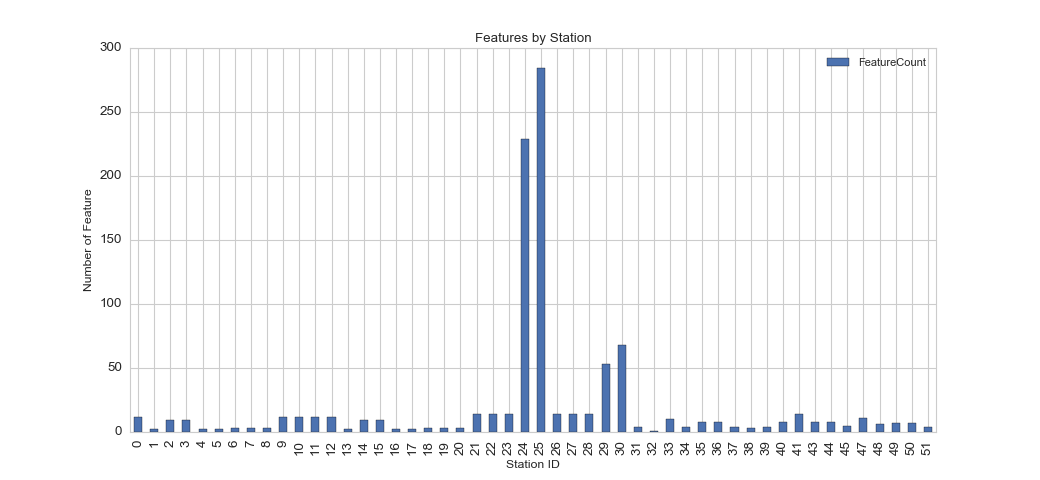

<IPython.core.display.Javascript object>


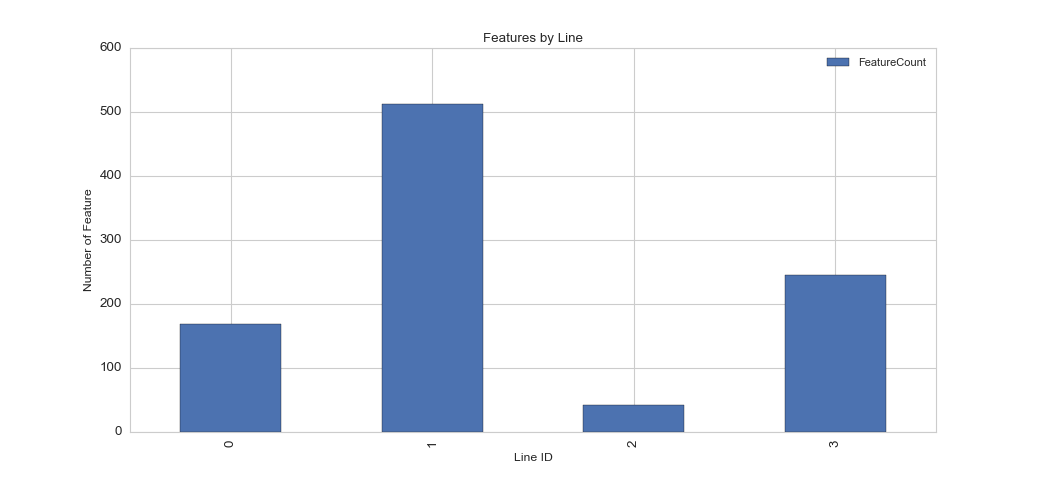

In [14]:
lf, sf = explore_features("train_numeric",True)

This part is to see how many parts per station, how many success and failure parts per station

In [19]:
def explore_product_by_station(data_set_name,read_rows):
    # need to see how many product per station
    # features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Response", "Id"], axis=1).columns.values
    # line_features, station_features = get_features(features)
    station_features = sf
    dwb_result = []
    ppbs_result = []
    rows = 0
    # inside this loop we will try to calculate different data sets, this way we only read the
    # files once since it takes a while and produce multiple results
    for station in station_features:
        station_data = pd.read_csv(
            INPUT_PATH % data_set_name,
            usecols=station_features[station] + ['Id', 'Response'],nrows = read_rows)
        
        # need to get how many rows in the sample row
        if not rows:
            rows = station_data.shape[0]
        # need to store how many processed units in each station
        # only if all features in that station has value we conside unit processed in this station
        ppbs_result.append(
            {'Station': int(station[1:]),
             'Processed': station_data[station_features[station]]
             .all(axis=1).sum()})
        
        # data without blanks (dwb): take all rows and drop any row that has any blank
        # in any station column
        dwb = station_data.dropna(how="any")
        dwb_result.append([int(station[1:]), dwb.shape[0],
                       dwb[dwb["Response"] == 1].shape[0],
                       dwb[dwb["Response"] == 0].shape[0]])
        
    # convert list to a dataframe and prepare for the plot
    dwb_df = pd.DataFrame(
        dwb_result, columns=["Station", "Count", "Failed", "Passed"]).sort_values(by=["Station"])
    # calculate the error rate for each station
    dwb_df["Error"] = dwb_df.apply(lambda row: float(row["Failed"]) / (row["Count"] + 1), axis=1)
    
    # plot the stacked bar tot product/ station
    my_plot = dwb_df[["Station", "Failed", "Passed"]].plot(kind="bar", stacked=True, x="Station",
        title="Products by station", figsize=(13,6), fontsize=12)
    my_plot.set_xlabel("Station ID")
    my_plot.set_ylabel("Number of Products")
    
    # plot error rate per station
    my_plot = dwb_df[["Station", "Error"]].plot(
        kind="bar", x="Station",
        title="Error by station", figsize=(13,6), fontsize=12)
    my_plot.set_xlabel("Station ID")
    my_plot.set_ylabel("Error Percentage")
    
    # process the ppbs result to see how many products has been process by each station.
#     ppbs_df = pd.DataFrame(
#         ppbs_result, columns=['Station', 'Processed']).sort(columns=['Station'])
#     # calculate the missed product for each station: all count - processed count
#     ppbs_df["Missed"] = ppbs_df["Processed"].apply(lambda x: rows - x)
#     # the plot
#     ppbs_df.plot(x="Station", kind="bar", stacked=True,
#             title="Fig: 5 - Products processed by each station",
#             figsize=(13,6), fontsize=12)
    



In [20]:
explore_product_by_station("train_numeric", 1184687)

KeyboardInterrupt: 

In [ ]:
# Value exploration by station part

In [ ]:
# overview again to compare with latter results
train_overview = pd.read_csv(INPUT_PATH % 'train_numeric',nrows = read_rows)
train_overview.head()

In [ ]:
# overview again with respect to a station
def get_station(dataset, station, res = False, show_figure = True):
    overview = pd.read_csv(INPUT_PATH % dataset,nrows = read_rows)
#     print overview.head()
    if res:
        columns = overview.columns.drop(["Response", "Id"])
    else:
        columns = overview.columns.drop(["Id"])
        
    stations = set([item.split('_')[1] for item in list(columns)])
    station_features = {}
    for s in stations:
        station_features[s] = [item for item in list(columns) if '%s_' % s in item]  
#     print overview[station_features[station]].head()
    print np.unique(overview[station_features[station]].values)
    
    overview_explore_nan = pd.DataFrame(columns = stations) 
    # prepare for dataset with one station
    # if contain values not nan
    # if no values nan
    for s in stations:
        overview_explore_nan[s] = overview[station_features[s][0]]
    overview_explore_nan =overview_explore_nan[sorted(overview_explore_nan.columns, key=lambda item: int(item[1:]))]
    # visualize result in flow path
    msno.matrix(overview_explore_nan)
    # visualize result in bar counting total number of non-nan value
    # msno.bar(overview_explore_nan)
    # visualize result in correlation coeficient
    msno.heatmap(overview_explore_nan)

In [ ]:
# train_numeric
# train_date
# train_categorical
get_station('train_numeric', 'S0', True)

In [ ]:
get_station('train_date', 'S1', False)

In [ ]:
get_station('train_categorical', 'S32', False)

## Categorial Data Exploration Part

In [ ]:
lf, sf = explore_features("train_categorical",False)

In [ ]:
# this function is to explore sparsity rate per row
def explore_sparse_rate(data_set_name, read_rows):
    train_categorical = pd.read_csv(INPUT_PATH % data_set_name,nrows = read_rows).drop(["Id"], axis=1)
    sparse_rate_each_part = []
    sparse_rate_series = train_categorical.isnull().sum(axis = 1)/train_categorical.shape[1]
    sparse_rate_df = pd.DataFrame(
        sparse_rate_series, columns=['sparse_rate'])
    return sparse_rate_df

In [ ]:
explore_sparse_rate('train_categorical', 100)

In [ ]:
# This function is to get feeling of the TX value in the dataset
def explore_dintinct_Tx_value(data_set_name, read_rows):
    train_categorical = pd.read_csv(INPUT_PATH % 'train_categorical',nrows = read_rows)
    del train_categorical['Id']
    train_categorical_zeroes = train_categorical.fillna(0)
    train_categorical_zeroes = train_categorical_zeroes.values 
    return np.unique(train_categorical_zeroes[train_categorical_zeroes!=0.0])

In [ ]:
explore_dintinct_Tx_value('train_categorical', 30)

# Feature Enginnering Part

## Method 1 : Applying PCA for Dimension Reduction
Preliminary work to search for appropriate n component
benchmark: how many variance is explained or we maintain how much variance
This model isn't added for feature engineeing by now

In [7]:
# import additional pakage
import math
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn import preprocessing
# define chunksize how many rows load one time
chunksize  = 50000

In [ ]:
# Getting the column headers from first rows
# Reading as float32 to save Memory 
data = pd.read_csv(INPUT_PATH % 'train_numeric',nrows=1)
float_cols = [c for c in data]
float32_cols = {c: np.float32 for c in float_cols}

In [ ]:
# define the number of pc for preliminary decomposition
n_components = 968
predictors = [x for x in data.keys() if (x != 'Response' and x != 'Id')]

In [ ]:
def standard_feature_scaling(df):
    std_scale = preprocessing.StandardScaler().fit(df)
    df_std = pd.DataFrame(std_scale.transform(df))
    df_std.columns = df.columns
    df_std.index = df.index
    return df_std

In [ ]:
def mean_imputer(DF):
    fill_NaN = preprocessing.Imputer(missing_values=np.nan, strategy='median')
    imputed_DF = pd.DataFrame(fill_NaN.fit_transform(DF))
    imputed_DF.columns = DF.columns
    imputed_DF.index = DF.index
    return imputed_DF

In [ ]:
ipca = IncrementalPCA(n_components=968)
# Due to the large dataset read data seperately in chunks and perform IncrementalPCA 
counter = 0
for chunk in pd.read_csv(INPUT_PATH % 'train_numeric', chunksize=chunksize,dtype=float32_cols):
    counter += chunksize
    print ('processed',counter,'samples')
# To do: what value to fill NA 
    imputed_chunk = chunk[predictors].fillna(0.09)
    #imputed_chunk = mean_imputer(chunk[predictors])
    scailed_chunk = standard_feature_scaling(imputed_chunk)
#    chunk  = scailed_chunk.fillna(0)
    ipca.partial_fit(scailed_chunk)
print ('Number of Samples Seen:',ipca.n_samples_seen_ )


In [ ]:
def get_explained_variance(pca_components):
    #print ('Explained variance by %d PCs:' %pca_components, np.sum(ipca.explained_variance_ratio_[:pca_components]))
    return np.sum(ipca.explained_variance_ratio_[:pca_components])

In [ ]:
# plot how many variance is explained based on how many n_components
n_components_value = range(968)
n_components_explained_variance = [get_explained_variance(x) for x in n_components_value]
explained_variance_pd = pd.DataFrame(n_components_explained_variance, columns=['explained_variance_rate'])
my_plot = explained_variance_pd.plot(title="explained_variance_rate", figsize=(10,6), fontsize=12)
my_plot.set_ylabel("Explained Variance Rate")
my_plot.set_xlabel("Number of Component")
n_components_explained_variance

In [ ]:
# Make Train DataFrame only with n PC 
PC_n = ['f'+str(x) for x in range(0,n_components)]
date_final = pd.DataFrame(columns=PC_n)
for cat in pd.read_csv(INPUT_PATH % 'train_numeric', chunksize=chunksize,dtype=float32_cols):
        cat  = cat.fillna(999)
        y=ipca.transform(cat[predictors])
        temp = cat['Id'].to_frame()
        for i in PC_n:
            temp[i]=0
        temp[PC_n]=y
        date_final = date_final.merge(temp, how='outer')
print (date_final)
date_final['Id'] = date_final['Id'].astype(np.int32)
# save new dataset to CSV file 
train_filename = 'train_numeric_SVD_%s.csv' % n_components
#date_final.to_csv(INPUT_PATH % train_filename,index=0)

In [ ]:
# Make Test DataFrame only with n PC 
PC_n = ['f'+str(x) for x in range(0,n_components)]
date_final = pd.DataFrame(columns=PC_n)
for cat in pd.read_csv('../input/test_numeric.csv', chunksize=chunksize,dtype=float32_cols):
        cat  = cat.fillna(999)
        y=ipca.transform(cat[predictors])
        temp = cat['Id'].to_frame()
        for i in PC_n:
            temp[i]=0
        temp[PC_n]=y
        date_final = date_final.merge(temp, how='outer')
date_final['Id'] = date_final['Id'].astype(np.int32)
test_filename = 'test_numeric_SVD_%s.csv' % n_components
# Save dataset to CSV file
#date_final.to_csv(INPUT_PATH % test_filename,index=0)

## Method 2 : XGBoost to select important features

choose 25 top date and numerical features reported by initial xgboost

In [ ]:
# Sample the data in a roundabout way to get 5 percent sample
date_chunks = pd.read_csv("../data/train_date.csv", index_col=0, chunksize=10000, dtype=np.float32)
num_chunks = pd.read_csv("../data/train_numeric.csv", index_col=0,
                         usecols=list(range(969)), chunksize=10000, dtype=np.float32)
df_train = pd.concat([pd.concat([dchunk, nchunk], axis=1).sample(frac=0.05)
               for dchunk, nchunk in zip(date_chunks, num_chunks)])
y_sample = pd.read_csv("../data/train_numeric.csv", index_col=0, usecols=[0,969], dtype=np.float32).loc[df_train.index].values.ravel()
x_sample = df_train.values

In [ ]:
# # now just numerical feature to see the result
# num_chunks = pd.read_csv("../data/train_numeric.csv", index_col=0,
#                          usecols=list(range(969)), chunksize=10000, dtype=np.float32)
# df_train = pd.concat([nchunk for nchunk in num_chunks])

In [ ]:
#TODO fit y ravel or not?
clf = XGBClassifier(base_score=0.005)
clf.fit(x_sample, y_sample)

In [ ]:
fea_importance = pd.DataFrame(clf.feature_importances_)
fea_importance.index = df_train.columns
fea_importance.columns=["feature_importance"]
# select 25 most important feature for xgboost
fea_importance_sorted = fea_importance.sort(['feature_importance'], ascending=[0])
important_feature_num_date = fea_importance_sorted.ix[0:25,0]
important_feature_num_date.plot(kind='bar')

In [ ]:
date_feature_value = pd.read_csv(INPUT_PATH % 'train_date',nrows=1).columns.drop(['Id']).values.tolist()
important_feature_num_list = list(set(important_feature_num_date.index.values.tolist())-set(date_feature_value))
important_feature_date_list = list(set(important_feature_num_date.index.values.tolist())-set(important_feature_num_list))

In [ ]:
# load entire dataset for these features. 
X = np.concatenate([
    pd.read_csv("../data/train_date.csv", index_col=0, dtype=np.float32,
                usecols=['Id']+important_feature_date_list).values,
    pd.read_csv("../data/train_numeric.csv", index_col=0, dtype=np.float32,
                usecols=['Id']+important_feature_num_list).values
], axis=1)

y = pd.read_csv("../data/train_numeric.csv", index_col=0, dtype=np.float32, usecols=[0,969]).values.ravel()

In [ ]:
# create important feature dataframe and plot
fea_importance = pd.DataFrame(clf.feature_importances_)
fea_importance.index = df_train.columns
fea_importance.columns=["feature_importance"]

fea_importance_new = fea_importance[fea_importance.feature_importance >0.005]
fea_importance_new.plot(kind="bar")

In [ ]:
# threshold for a manageable number of features
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_>0.005)[0]
print(important_indices)

In [ ]:
# load entire dataset for these features. 
# note where the feature indices are split so we can load the correct ones straight from read_csv
n_date_features = 1156
X = np.concatenate([
    pd.read_csv("../data/train_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices < n_date_features] + 1])).values,
    pd.read_csv("../data/train_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices >= n_date_features] + 1 - n_date_features])).values
], axis=1)

y = pd.read_csv("../data/train_numeric.csv", index_col=0, dtype=np.float32, usecols=[0,969]).values.ravel()

In [ ]:
# --------------------------------
# select top 20 important numerical feature
num_chunks = pd.read_csv("../data/train_numeric.csv", index_col=0,
                         usecols=list(range(969)), chunksize=10000, dtype=np.float32)

## Method 3 : Magic Feature 
This features are reported by Faron in the forum

Start time.   Component(part) production start time

MF1.  difference of Id between current and previous rows 

MF2.  difference of Id between current and next rows 

MF3.  difference of Id between current and previous rows after sorting on increasing StartTime and Id

MF4.  difference of Id between current and next rows after sorting on increasing StartTime and Id


In [14]:
ID_COLUMN = 'Id'
TARGET_COLUMN = 'Response'
train = pd.read_csv(INPUT_PATH %'train_numeric', usecols=[ID_COLUMN, TARGET_COLUMN])

test = pd.read_csv(INPUT_PATH %'test_numeric', usecols=[ID_COLUMN])

In [15]:
# Start Time feature
train["StartTime"] = -1
test["StartTime"] = -1
# Duration time feature
train["Duration"] = -1
test["Duration"] = -1

In [16]:
# fill in start time
for tr, te in zip(pd.read_csv(INPUT_PATH %'train_date', chunksize=50000), pd.read_csv(INPUT_PATH %'test_date', chunksize=50000)):
    #pick all columns except ID
    feats = np.setdiff1d(tr.columns, [ID_COLUMN])

    stime_tr = tr[feats].min(axis=1).values
    stime_te = te[feats].min(axis=1).values
    
    etime_tr = tr[feats].max(axis=1).values
    etime_te = te[feats].max(axis=1).values

    train.loc[train.Id.isin(tr.Id), 'StartTime'] = stime_tr
    test.loc[test.Id.isin(te.Id), 'StartTime'] = stime_te
    
    train.loc[train.Id.isin(tr.Id), 'Duration'] = etime_tr - stime_tr
    test.loc[test.Id.isin(te.Id), 'Duration'] = etime_te - stime_te

In [17]:
ntrain = train.shape[0]
train_test = pd.concat((train, test)).reset_index(drop=True).reset_index(drop=False)
# Begin to create MF1 & MF2
train_test['MF1'] = train_test[ID_COLUMN].diff().fillna(9999999).astype(int)
train_test['MF2'] = train_test[ID_COLUMN].iloc[::-1].diff().fillna(9999999).astype(int)

train_test = train_test.sort_values(by=['StartTime', 'Id'], ascending=True)
# Begin to create MF3 & MF4
train_test['MF3'] = train_test[ID_COLUMN].diff().fillna(9999999).astype(int)
train_test['MF4'] = train_test[ID_COLUMN].iloc[::-1].diff().fillna(9999999).astype(int)

train_test = train_test.sort_values(by=['index']).drop(['index'], axis=1)
train = train_test.iloc[:ntrain, :]
test = train_test.iloc[ntrain:, :]

features = np.setdiff1d(list(train.columns), [TARGET_COLUMN, ID_COLUMN])

In [18]:
df_magic_feature_train = train[features]
df_magic_feature_test = test[features]

In [20]:
df_magic_feature_train.shape

(1183747, 6)

In [ ]:
# ntrain = train.shape[0]
# train_test = pd.concat((train, test)).reset_index(drop=True).reset_index(drop=False)
# # Begin to create MF1 & MF2
# train_test['MF1'] = train_test[ID_COLUMN].diff().fillna(9999999).astype(int)
# train_test['MF2'] = train_test[ID_COLUMN].iloc[::-1].diff().fillna(9999999).astype(int)

# train_test = train_test.sort_values(by=['StartTime', 'Id'], ascending=True)
# # Begin to create MF3 & MF4
# train_test['MF3'] = train_test[ID_COLUMN].diff().fillna(9999999).astype(int)
# train_test['MF4'] = train_test[ID_COLUMN].iloc[::-1].diff().fillna(9999999).astype(int)

# train_test = train_test.sort_values(by=['index']).drop(['index'], axis=1)
# train = train_test.iloc[:ntrain, :]

# features = np.setdiff1d(list(train.columns), [TARGET_COLUMN, ID_COLUMN])

# y = train.Response.ravel()
# train = np.array(train[features])

# print('train: {0}'.format(train.shape))
# prior = np.sum(y) / (1.*len(y))

## Combine all features and Finish feature engineering

In [ ]:
# train_feature will be the ensembled feature afterwards
train_feature = pd.DataFrame(X)


In [ ]:
# put important feature in the dataframe 
train_feature.columns = important_feature_num_date.index
train_feature = pd.concat([train_feature,df_magic_feature_train],axis=1)
#end of feature selection

In [ ]:
train_feature.shape

## Select Engineered features from R and feature tuning

These are currently used feature from the R script
see feature engineering R file in the same directory

In [3]:
def strategy_imputer(DF,strategy="median"):
    fill_NaN = preprocessing.Imputer(missing_values=np.nan, strategy=strategy)
    imputed_DF = pd.DataFrame(fill_NaN.fit_transform(DF))
    imputed_DF.columns = DF.columns
    imputed_DF.index = DF.index
    return imputed_DF

In [4]:
tl_df = pd.read_csv("../input/engineered_feature.csv", index_col=0, dtype=np.float32)
train_index = tl_df["target"].notnull()
test_index = tl_df["target"].isnull()

In [5]:
# a=pd.read_csv("../data/name1.csv", index_col=0, dtype=np.float32)

In [6]:
# fill in missing values before loading into the model
# tl_imputed=strategy_imputer(tl_df)
tl_imputed = tl_df.fillna(0)
tl_train = tl_imputed[train_index]
tl_test = tl_imputed[test_index]
target_y = tl_train["target"]
del tl_train["target"]
del tl_test["target"]
# tl_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 
#             'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 
#             'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18',
#             'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27']

In [7]:
# convert into ndarray
train_x = tl_train.values
train_y = target_y.values
test_x = tl_test.values

# Model Development 

## Model 0: Decision Tree－starter

In [15]:
from sklearn import tree
clf_decisiontree = tree.DecisionTreeClassifier()
# report_out_of_fold_score(clf_decisiontree,train_x)

In [12]:
clf_decisiontree.fit(train_x, train_y)
make_submission(clf_decisiontree, best_threshold=0.142)

0.142
submission.csv.gz


## Model 1 : XGBoost

In [29]:
# self-defined xgb model wrapper including data processing, model fit, predict and result 
def modelfit(alg, dtrain, labels,useTrainCV=True, model_fit=True, fea_impor=True, model_predict=True,cv_folds=5, early_stopping_rounds=30):
    # trainCV with early stop so we don't need to use sciki-learn GridsearchCV , the later can't run in my computer
    best_threshold = 0.5
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain, label=labels)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                        metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
#         print cvresult
#         return
        alg.set_params(n_estimators=cvresult.shape[0])
        plt.figure(8)
        plt.plot(range(alg.get_params()['n_estimators']), cvresult["train-auc-mean"].values)
        plt.plot(range(alg.get_params()['n_estimators']), cvresult["test-auc-mean"].values)
        plt.legend(['train', 'test'], loc='upper left')
        plt.xlabel('training rounds')
        plt.ylabel('Auc')
        plt.show()
    if model_fit:
        #Fit the algorithm on the data
        alg.fit(dtrain, labels, eval_metric='auc')
        print ("fit done")
    if fea_impor:
        plt.figure(9)
        feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()
    if model_predict:
    #Predict training set:
        dtrain_predprob = alg.predict_proba(dtrain.values)[:,1]
        thresholds = np.linspace(0.01, 0.99, 50)
        mcc = np.array([matthews_corrcoef(labels, dtrain_predprob>thr) for thr in thresholds])    
        plt.figure(10)
        plt.plot(thresholds, mcc)
        plt.show()
        best_threshold = thresholds[mcc.argmax()]
        print('MCC is' + str(mcc.max()))
        print('best threshold is'+ str(best_threshold))
    return best_threshold
    
        
    #Print model report:
#     print ("\nModel Report")
#     print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
#     print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [125]:
### Training and Cross Validation Part

In [304]:
xgb_starter = XGBClassifier(
 learning_rate =0.05,
 n_estimators=91,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=0.85,
 colsample_bytree=0.5,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=0)

# xgb_starter.fit(train_x,train_y)

# train_x = tl_train.values
# train_y = target_y.values

# report_out_of_fold_score(xgb_starter)
# best_threshold = modelfit(xgb_starter, train_x, train_y.ravel())
# best_threshold = 0.318

In [87]:
make_submission(xgb_starter,best_threshold=0.318)

submission.csv.gz


In [89]:
get_out_of_fold_prediction(xgb_starter,"XGBoost",5,)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


In [9]:
def report_out_of_fold_score(clf_test,train_x):
    n_folds=5
    skf = StratifiedKFold(target_y, n_folds)

    
    preds = np.ones(train_y.shape[0])
    aucs=np.ones(n_folds)
    mccs=np.ones(n_folds)
    ths=np.ones(n_folds)
    for i, (train, test) in enumerate(skf):
        print "Fold", i
        clf_test.fit(train_x[train], train_y[train])
#         print("fold {}, best round: {}".format(i, clf_test.best_round))
        preds[test] =clf_test.predict_proba(train_x[test])[:,1]
        print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(train_y[test], preds[test])))
        thresholds = np.linspace(0.01, 0.99, 50)
        mcc = np.array([matthews_corrcoef(train_y[test], preds[test]>thr) for thr in thresholds])  
        print("fold {}, TH: {:.3f}, MCC: MAX {:.3f}".format(i,thresholds[mcc.argmax()],mcc.max()))
        ths[i]=thresholds[mcc.argmax()]
        aucs[i]=roc_auc_score(train_y[test], preds[test])
        mccs[i]=mcc.max()
    print("mean out of fold AUC "+str(np.mean(aucs)))
    print("mean out of fold MCC "+str(np.mean(mccs)))
    print("mean out of fold ths "+str(np.mean(ths)))

In [ ]:
def report_out_of_fold_score_predict(clf_test):
    n_folds=5
    skf = StratifiedKFold(target_y, n_folds)


    preds = np.ones(train_y.shape[0])
    aucs=np.ones(n_folds)
    mccs=np.ones(n_folds)
    for i, (train, test) in enumerate(skf):
        print "Fold", i
        clf_test.fit(train_x[train], train_y[train])
        preds[test] = clf_test.predict(train_x[test])
        print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(train_y[test], preds[test])))
#         thresholds = np.linspace(0.01, 0.99, 50)
        mcc = matthews_corrcoef(train_y[test], preds[test])
        print("fold {}, MCC: MAX {:.3f}".format(i,mcc))
        aucs[i]=roc_auc_score(train_y[test], preds[test])
        mccs[i]=mcc
    print("mean out of fold AUC "+str(np.mean(aucs)))
    print("mean out of fold MCC "+str(np.mean(mccs)))
    

## Model 2 random forest
This model gived AUC  (91%), MCC (MCC 0.47)

In [ ]:
n_folds=5
skf = StratifiedKFold(target_y, n_folds)
# clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy')
clf_fold = RandomForestClassifier(n_estimators = 100, n_jobs = -1,random_state =1, 
                             max_features = "auto", min_samples_leaf =3 ,criterion='entropy' )
preds = np.ones(train_y.shape[0])

In [3]:
clf_rf_entropy = RandomForestClassifier(n_estimators = 100, oob_score = True, n_jobs = -1,random_state =1, 
                             max_features = "auto", min_samples_leaf = 3,criterion='entropy')

# clf_rf_entropy.fit(train_x,train_y)
# make_submission(clf_rf_entropy,best_threshold = 0.29)
# report_out_of_fold_score(clf_rf_entropy,train_x)

In [11]:
get_out_of_fold_prediction(clf_rf_entropy,"rf_entropy",5)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


In [14]:
clf_rf_gini = RandomForestClassifier(n_estimators = 100, n_jobs = -1,random_state =1, 
                             max_features = "auto", min_samples_leaf = 3,criterion='gini')

# report_out_of_fold_score(clf_rf_gini,train_x)
clf_rf_gini.fit(train_x,train_y)
make_submission(clf_rf_gini,best_threshold = 0.29 )

In [15]:
get_out_of_fold_prediction(clf_rf_gini,"rf_gini",5)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


## Model 3 Extra tree classifier 

In [ ]:
clf_extr_entropy = ExtraTreesClassifier(n_estimators=150, n_jobs=-1, criterion='entropy',
                               max_features="auto", min_samples_leaf=3, random_state=0)

report_out_of_fold_score(clf_extr_entropy,train_x)
# clf_extr_entropy.fit(train_x,train_y)
# make_submission(clf_extr_entropy,best_threshold = 0.298)


In [105]:
get_out_of_fold_prediction(clf_extr_entropy,"extr_entropy",5)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


In [24]:
clf_extr_gini = ExtraTreesClassifier(n_estimators=150, n_jobs=-1, criterion='gini',
                               max_features="auto", min_samples_leaf=3, random_state=0)
# report_out_of_fold_score(clf_extr_gini,train_x)
clf_extr_gini.fit(train_x,train_y)
make_submission(clf_extr_gini,best_threshold = 0.306)

0.306
submission.csv.gz


In [23]:
get_out_of_fold_prediction(clf_extr_gini,"extr_gini",5)
# clf_extr_gini.get_params().keys()

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


## Model 4 LightGBM

In [42]:
exec_path = "~/Desktop/project/LightGBM/lightgbm"

In [76]:
clf_lightgbm = GBMClassifier(exec_path=exec_path,early_stopping_round=10,verbose=True,
                            learning_rate=0.15,num_iterations=100, min_data_in_leaf=3,metric="roc_auc")

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable


In [ ]:
report_out_of_fold_score(clf_lightgbm,train_x)

In [ ]:
clf_lightgbm.fit(train_x,train_y)

In [79]:
make_submission(clf_lightgbm,best_threshold = 0.47)

[LightGBM] [Info] Finished loading parameters
[LightGBM] [Info] Finished loading 100 models
[LightGBM] [Info] Finished initializing prediction
[LightGBM] [Info] Finished prediction
submission.csv.gz


In [ ]:
get_out_of_fold_prediction(clf_lightgbm,"lightGBM",5)

In [80]:
def get_threshold(clf):
    pred = clf.predict_proba(train_x)[:,1]
    thresholds = np.linspace(0.01, 0.99, 50)
    mcc = np.array([matthews_corrcoef(train_y, pred>thr) for thr in thresholds])    
    plt.figure(10)
    plt.plot(thresholds, mcc)
    plt.show()
    best_threshold = thresholds[mcc.argmax()]
    print('MCC is' + str(mcc.max()))
    print('best threshold is'+ str(best_threshold))
    return best_threshold

## Model 5 KNN
so slow, didn't include in first-round stacking

In [13]:
from sklearn import neighbors

In [14]:
def standard_feature_scaling(df):
    std_scale = preprocessing.StandardScaler().fit(df)
    df_std = pd.DataFrame(std_scale.transform(df))
    df_std.columns = df.columns
    df_std.index = df.index
    return df_std

In [15]:
tl_df = pd.read_csv("../input/engineered_feature.csv", index_col=0, dtype=np.float32)
train_index = tl_df["target"].notnull()
test_index = tl_df["target"].isnull()

In [23]:
# fill in missing values before RF
# tl_imputed=strategy_imputer(tl_df)
tl_imputed = tl_df.fillna(0)
tl_standarized = standard_feature_scaling(tl_imputed)
tl_train = tl_standarized[train_index]
tl_test = tl_standarized[test_index]
target_y = tl_imputed[train_index]["target"]
del tl_train["target"]

In [24]:
# convert into ndarray
train_x = tl_train.values
train_y = target_y.values

In [26]:
target_y.head()

ID
4.0     0.0
6.0     0.0
7.0     0.0
9.0     0.0
11.0    0.0
Name: target, dtype: float32

In [ ]:
n_neighbors=5
clf = neighbors.KNeighborsClassifier(n_neighbors)

In [ ]:
report_out_of_fold_score(clf)

## Model 6 Kernel SVM
So slow, didn't include in first-round stacking

In [ ]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf',probability=True,C=1,gamma='auto')
report_out_of_fold_score(clf)

## Model 7 Adaboost
So slow, didn't include in first-round stacking

In [2]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
bdt = AdaBoostClassifier(random_state=1,
                         learning_rate=1,
                         n_estimators=200)
report_out_of_fold_score(bdt)

## Model 8 GBM 
Slower than xgboost, didn't add now

## Model Hyper-Parameter Tuning Part
This place is using gridsearch cv for hyper-parameter tuning

In [16]:
from sklearn import tree
clf_decisiontree = tree.DecisionTreeClassifier()
# report_out_of_fold_score(clf_decisiontree,train_x)

In [19]:
param_grid = {'min_samples_leaf': [1,2,3], 'criterion': ['entropy','gini']}
# clf_decisiontree.fit(train_x, train_y)
random_search_report(clf_decisiontree, param_grid, train_x, n_iter=6)
# make_submission(clf_decisiontree, best_threshold=0.142)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 12.5min finished


('Grid score: ', [mean: 0.65871, std: 0.00740, params: {'criterion': 'entropy', 'min_samples_leaf': 1}, mean: 0.64745, std: 0.00434, params: {'criterion': 'entropy', 'min_samples_leaf': 2}, mean: 0.65457, std: 0.00453, params: {'criterion': 'entropy', 'min_samples_leaf': 3}, mean: 0.65817, std: 0.00603, params: {'criterion': 'gini', 'min_samples_leaf': 1}, mean: 0.64406, std: 0.00641, params: {'criterion': 'gini', 'min_samples_leaf': 2}, mean: 0.64625, std: 0.00724, params: {'criterion': 'gini', 'min_samples_leaf': 3}])
('Best score: ', 0.65871215814035466)
('Best params: ', {'criterion': 'entropy', 'min_samples_leaf': 1})


In [39]:
param_grid = {'learning_rate': [0.05], 'n_estimators': [50,60,70],
              'subsample':[0.75,0.8,0.85],'colsample_bytree':[0.45,0.5,0.55]}

xgb_starter = XGBClassifier(
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=0)

random_search_report(xgb_starter,param_grid)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 41.1min finished


('Grid score: ', [mean: 0.44830, std: 0.01416, params: {'n_estimators': 50, 'subsample': 0.75, 'learning_rate': 0.05, 'colsample_bytree': 0.55}, mean: 0.45161, std: 0.01662, params: {'n_estimators': 60, 'subsample': 0.85, 'learning_rate': 0.05, 'colsample_bytree': 0.55}, mean: 0.44767, std: 0.01477, params: {'n_estimators': 50, 'subsample': 0.75, 'learning_rate': 0.05, 'colsample_bytree': 0.5}, mean: 0.44977, std: 0.01641, params: {'n_estimators': 60, 'subsample': 0.85, 'learning_rate': 0.05, 'colsample_bytree': 0.5}, mean: 0.45143, std: 0.01347, params: {'n_estimators': 60, 'subsample': 0.75, 'learning_rate': 0.05, 'colsample_bytree': 0.5}, mean: 0.45436, std: 0.01401, params: {'n_estimators': 70, 'subsample': 0.85, 'learning_rate': 0.05, 'colsample_bytree': 0.5}])
('Best score: ', 0.45436296098171319)
('Best params: ', {'n_estimators': 70, 'subsample': 0.85, 'learning_rate': 0.05, 'colsample_bytree': 0.5})


In [36]:
# this part is for tune extraclass
clf_extr_entropy = ExtraTreesClassifier(n_jobs=-1, criterion='entropy',
                               max_features=None, random_state=0)
param_grid = {'n_estimators': [30,50,70], 
              'min_samples_split':[3,5,7]}
# estimator.get_params().keys()
random_search_report(clf_extr_entropy,param_grid)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 86.1min finished


('Grid score: ', [mean: 0.64002, std: 0.00621, params: {'n_estimators': 30, 'min_samples_split': 5}, mean: 0.63618, std: 0.00667, params: {'n_estimators': 50, 'min_samples_split': 7}, mean: 0.64099, std: 0.00642, params: {'n_estimators': 30, 'min_samples_split': 3}, mean: 0.64253, std: 0.00663, params: {'n_estimators': 50, 'min_samples_split': 3}, mean: 0.63901, std: 0.00600, params: {'n_estimators': 50, 'min_samples_split': 5}, mean: 0.64268, std: 0.00650, params: {'n_estimators': 70, 'min_samples_split': 3}])
('Best score: ', 0.64267958002964609)
('Best params: ', {'n_estimators': 70, 'min_samples_split': 3})


In [ ]:
#this part is for tune LightGBM using gridSearch CV
import numpy as np
from pylightgbm.models import GBMClassifier

# full path to lightgbm executable (on Windows include .exe)
exec_path = "~/Desktop/project/LightGBM/lightgbm"

clf_gbm = GBMClassifier(exec_path=exec_path,early_stopping_round=10,verbose=True,application='binary')

param_grid = {'learning_rate': [0.15], 'num_iterations': [80],
              'min_data_in_leaf':[3]}

# scorer = metrics.make_scorer(metrics.matthews_corrcoef, greater_is_better=True)
# AUC score for robust determination
# clf = grid_search.GridSearchCV(gbm, param_grid, scoring='roc_auc', cv=2,verbose=True)
# MCC score for best prediction dermnation
# grid_search_report(clf_gbm,param_grid) 
random_search_report(clf_gbm,param_grid)

In [ ]:
# this part is for tune KNN
clf_KNN = neighbors.KNeighborsClassifier()
param_grid = {'n_neighbors': [5]}
grid_search_report(clf_KNN,param_grid) 

In [ ]:
# this part is for tune SVM
from sklearn.svm import SVC
clf_SVM = SVC(kernel='linear',probability=True)
param_grid = {'C': [1],
             'gamma': ["auto"]}
grid_search_report(clf_SVM,param_grid)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [16]:
#this part is for tune Adaboost
from sklearn.ensemble import AdaBoostClassifier
clf_ada = AdaBoostClassifier(random_state=1)
param_grid = {'learning_rate': map(lambda x: x/10.0, range(1, 5, 1)),
             'n_estimators': [100,200,300]}
random_search_report(clf_ada,param_grid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 155.9min finished


('Grid score: ', [mean: 0.35109, std: 0.00884, params: {'n_estimators': 300, 'learning_rate': 0.2}, mean: 0.23069, std: 0.01868, params: {'n_estimators': 100, 'learning_rate': 0.2}, mean: 0.35500, std: 0.00981, params: {'n_estimators': 200, 'learning_rate': 0.4}, mean: 0.34404, std: 0.01205, params: {'n_estimators': 100, 'learning_rate': 0.4}, mean: 0.09892, std: 0.01370, params: {'n_estimators': 100, 'learning_rate': 0.1}])
('Best score: ', 0.35499676770972161)
('Best params: ', {'n_estimators': 200, 'learning_rate': 0.4})


In [98]:
from sklearn.grid_search import GridSearchCV

# this function try to find the best paramter combination based 
# on n-fold cross validation score

def grid_search_report(clf, param_grid, train_x,nfold=5):
    scorer = metrics.make_scorer(metrics.matthews_corrcoef, greater_is_better=True)
    cl_gd =grid_search.GridSearchCV(clf, param_grid,scoring=scorer,cv=nfold,verbose=True)
    cl_gd.fit(train_x, train_y)
    
    print("Grid score: ",cl_gd.grid_scores_)
    print("Best score: ", cl_gd.best_score_)
    print("Best params: ", cl_gd.best_params_)
   

In [18]:
def random_search_report(clf, param_grid, train_x, nfold=5,n_iter=6):
    scorer = metrics.make_scorer(metrics.roc_auc_score, greater_is_better=True)
    clf_rd = grid_search.RandomizedSearchCV(clf, param_grid, scoring=scorer, n_iter=n_iter, cv=nfold,verbose=True)
    clf_rd.fit(train_x, train_y)
    
    print("Grid score: ",clf_rd.grid_scores_)
    print("Best score: ", clf_rd.best_score_)
    print("Best params: ", clf_rd.best_params_)

# Model Ensemble

In [5]:
# make Correlation matrix of base models
rl_lightGBM = pd.read_csv("../fold_result/1.csv", index_col=0, dtype=np.float32)
rl_xgb = pd.read_csv("../fold_result/2.csv", index_col=0, dtype=np.float32)
rl_rf_entr = pd.read_csv("../fold_result/3.csv", index_col=0, dtype=np.float32)
rl_et_entr = pd.read_csv("../fold_result/4.csv", index_col=0, dtype=np.float32)
rl_et_gini = pd.read_csv("../fold_result/5.csv", index_col=0, dtype=np.float32)
rl_rf_gini = pd.read_csv("../fold_result/6.csv", index_col=0, dtype=np.float32)

In [6]:
df_result = rl_lightGBM.join(rl_xgb,lsuffix='_lightGBM', rsuffix='_xgb').join(rl_rf_entr,lsuffix='', rsuffix='_rfentropy').join(rl_et_entr, lsuffix='', rsuffix='_etentropy').join(rl_et_gini,lsuffix='', rsuffix='_etgini').join(rl_rf_gini, lsuffix='', rsuffix='_rfgini')

In [8]:
df_result.columns=['lightGBM','xgb','rf_entropy','et_entropy','et_gini','rf_gini']

In [9]:
df_result.head()

,lightGBM,xgb,rf_entropy,et_entropy,et_gini,rf_gini
Id,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
corrmat = df_result.corr()

In [13]:
corrmat

,lightGBM,xgb,rf_entropy,et_entropy,et_gini,rf_gini
lightGBM,1.000000,0.867724,0.868983,0.851146,0.851288,0.870698
xgb,0.867724,1.000000,0.885971,0.881702,0.880864,0.885756
rf_entropy,0.868983,0.885971,1.000000,0.867796,0.854454,0.950945
et_entropy,0.851146,0.881702,0.867796,1.000000,0.960960,0.864410
et_gini,0.851288,0.880864,0.854454,0.960960,1.000000,0.850490
rf_gini,0.870698,0.885756,0.950945,0.864410,0.850490,1.000000


<IPython.core.display.Javascript object>


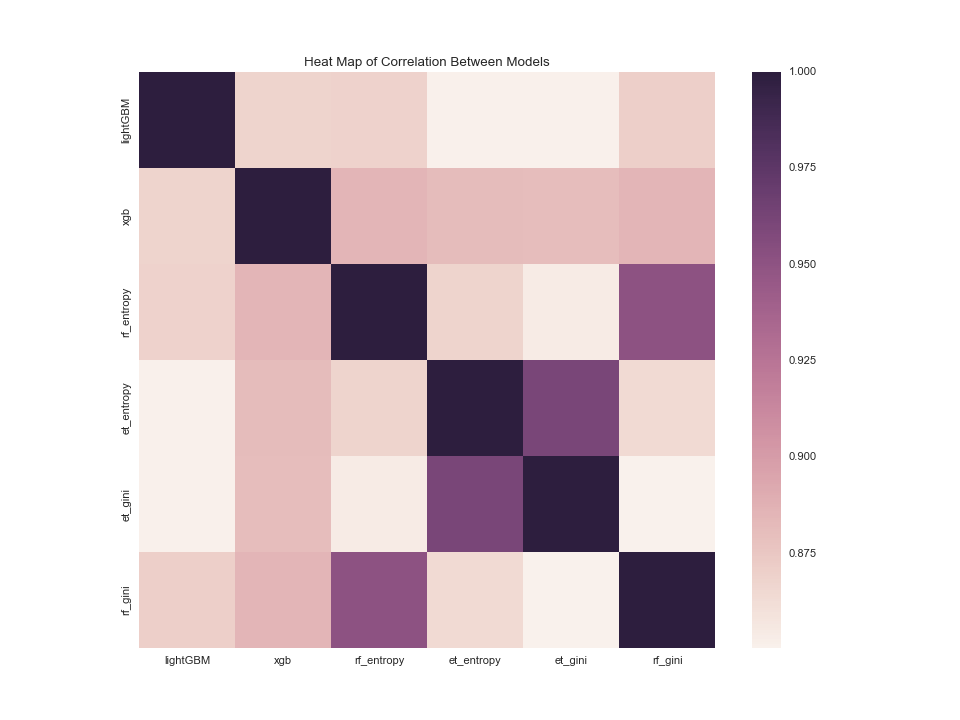

In [18]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,  square=True)
plt.title("Heat Map of Correlation Between Models")

In [87]:
# This function is to generate out-of-fold and test predictions
# SOME mistake about the row number
def get_out_of_fold_prediction(clf,name1,n_folds=5):
    skf = list(StratifiedKFold(train_y, n_folds))
    data_pred_out_of_fold = np.zeros(1183748)
    data_pred_test = np.zeros((1183748, len(skf)))
    for i, (train, test) in enumerate(skf):
        print "Fold", i
        clf.fit(train_x[train], train_y[train])
        data_pred_out_of_fold[test] = clf.predict_proba(train_x[test])[:,1]
        data_pred_test[:,i] = clf.predict_proba(test_x)[:, 1]
    data_pred_test_mean = data_pred_test.mean(1)
    name1=name1+"fold"
    name2=name1+"test"
    save1 = pd.DataFrame(data_pred_out_of_fold,columns=["prob"])
    save2 = pd.DataFrame(data_pred_test_mean,columns=["prob"])
    save1.to_csv("../data/"+name1+".csv")
    save2.to_csv("../data/"+name2+".csv")
    

In [21]:
light_fold = pd.read_csv("../fold_result/lightGBMfold.csv", index_col=0, dtype=np.float32)
light_test = pd.read_csv("../fold_result/lightGBMfoldtest.csv", index_col=0, dtype=np.float32)
extr_entropy_fold = pd.read_csv("../fold_result/extr_entropyfold.csv", index_col=0, dtype=np.float32)
extr_entropy_test = pd.read_csv("../fold_result/extr_entropyfoldtest.csv", index_col=0, dtype=np.float32)
extr_gini_fold = pd.read_csv("../fold_result/extr_ginifold.csv", index_col=0, dtype=np.float32)
extr_gini_test = pd.read_csv("../fold_result/extr_ginifoldtest.csv", index_col=0, dtype=np.float32)
rf_entropy_fold = pd.read_csv("../fold_result/rf_entropyfold.csv", index_col=0, dtype=np.float32)
rf_entropy_test = pd.read_csv("../fold_result/rf_entropyfoldtest.csv", index_col=0, dtype=np.float32)
rf_gini_fold = pd.read_csv("../fold_result/rf_ginifold.csv", index_col=0, dtype=np.float32)
rf_gini_test = pd.read_csv("../fold_result/rf_ginifoldtest.csv", index_col=0, dtype=np.float32)
xgb_fold = pd.read_csv("../fold_result/XGBoostfold.csv", index_col=0, dtype=np.float32)
xgb_test = pd.read_csv("../fold_result/XGBoostfoldtest.csv", index_col=0, dtype=np.float32)

In [22]:
# join to get train and test rows
train_l2 = light_fold.join(extr_entropy_fold,lsuffix='_light', rsuffix='_extrEntropy').join(extr_gini_fold,lsuffix='', rsuffix='_extrgini').join(rf_entropy_fold,lsuffix='', rsuffix='_rfEntropy').join(rf_gini_fold,lsuffix='', rsuffix='_rfgini').join(xgb_fold,lsuffix='', rsuffix='_xgb')
test_l2 = light_test.join(extr_entropy_test,lsuffix='_light', rsuffix='_extrEntropy').join(extr_gini_test,lsuffix='', rsuffix='_extrgini').join(rf_entropy_test,lsuffix='', rsuffix='_rfEntropy').join(rf_gini_test,lsuffix='', rsuffix='_rfgini').join(xgb_test,lsuffix='', rsuffix='_xgb')
# drop extra rows
train_l2 = train_l2.drop(train_l2.index[len(train_l2)-1])
# load train lable
# train_y

In [92]:
def logit(p):
    with precision(100000):
        return log(p)- log(1 -BigFloat(p))


In [23]:
train_l2 = train_l2.applymap(special.logit)
test_l2 = test_l2.applymap(special.logit)

In [24]:
train_l2 = train_l2.join(df_magic_feature_train,lsuffix='', rsuffix='')
test_l2 = test_l2.join(df_magic_feature_test,lsuffix='', rsuffix='')
# train_l2 = train_l2.replace([-np.inf],-16)
# train_l2 = train_l2.replace([np.inf],10)
# test_l2 = test_l2.replace([-np.inf],-16)
# test_l2 = test_l2.replace([np.inf],10)

In [25]:
train_l2.head()

,prob_light,prob_extrEntropy,prob,prob_rfEntropy,prob_rfgini,prob_xgb,Duration,MF1,MF2,MF3,MF4,StartTime
0.0,-9.127850,-8.483041,-8.685162,-10.618902,-10.187962,-5.253601,5.05,9999999,-2,-2314450,-224451,82.24
1.0,-7.045631,-6.352776,-6.074121,-inf,-6.193969,-5.146423,2.63,2,-1,-2284042,-67530,1313.12
2.0,-6.913125,-5.623464,-6.429771,-8.881556,-5.926097,-5.145325,5.72,1,-2,-2313512,-26876,1618.70
3.0,-5.942260,-6.210380,-6.605445,-7.223521,-7.990221,-5.191361,4.96,2,-2,-2196581,-3564,1149.20
4.0,-2.458716,-3.011298,-2.707870,-3.650078,-3.775202,-3.736954,3.38,2,-2,-2226678,-1,602.64


In [26]:
train_l2 = train_l2.values
test_l2 = test_l2.values

In [29]:
train_l2.shape

(1183747, 6)

In [38]:
test_l2.shape

(1183748, 12)

In [344]:
clf = LogisticRegression(solver="sag",max_iter=1000)
report_out_of_fold_score(clf,train_l2)
# clf.fit(train_l2,train_y)
# best_threshold=0.466
# make_submission_L2(clf,best_threshold=0.466)

Fold 0
fold 0, ROC AUC: 0.905
fold 0, TH: 0.450, MCC: MAX 0.472
Fold 1
fold 1, ROC AUC: 0.909
fold 1, TH: 0.570, MCC: MAX 0.485
Fold 2
fold 2, ROC AUC: 0.912
fold 2, TH: 0.190, MCC: MAX 0.470
Fold 3
fold 3, ROC AUC: 0.892
fold 3, TH: 0.390, MCC: MAX 0.458
Fold 4
fold 4, ROC AUC: 0.902


KeyboardInterrupt: 

In [100]:
clf_rf_gini_l2 = RandomForestClassifier(n_estimators = 100, n_jobs = -1,random_state =1, 
                             max_features = "auto", min_samples_leaf = 3,criterion='gini')
# param = {'n_estimators':[10,30,50,70,90]}
# clf_rf_gini_l2.fit(train_l2,train_y)
# make_submission(clf_rf_gini_l2,best_threshold = 0.29)
report_out_of_fold_score(clf_rf_gini_l2,train_l2)
# grid_search_report(clf_rf_gini_l2,param,train_l2)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 47.1min finished


('Grid score: ', [mean: 0.46541, std: 0.00993, params: {'n_estimators': 10}, mean: 0.46697, std: 0.00938, params: {'n_estimators': 30}, mean: 0.46898, std: 0.01108, params: {'n_estimators': 50}, mean: 0.46979, std: 0.01025, params: {'n_estimators': 70}, mean: 0.47069, std: 0.00963, params: {'n_estimators': 90}])
('Best score: ', 0.47069068433856481)
('Best params: ', {'n_estimators': 90})


In [41]:
# train a L2 xgboost
xgb_l2 = XGBClassifier(
 learning_rate =0.03,
 n_estimators=94,
 max_depth=8,
 min_child_weight=1,
 gamma=0,
 subsample=0.85,
 colsample_bytree=0.5,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=0)

# best_threshold = modelfit(xgb_l2, train_l2, train_y.ravel())
report_out_of_fold_score(xgb_l2,train_l2)
# xgb_l2.fit(train_l2,train_y)
# best_threshold=0.43
# make_submission(xgb_l2,best_threshold=0.438)
# try_threshold(xgb_l2)


# report_out_of_fold_score(xgb_starter)

Fold 0
fold 0, ROC AUC: 0.916
fold 0, TH: 0.410, MCC: MAX 0.473
Fold 1
fold 1, ROC AUC: 0.920
fold 1, TH: 0.510, MCC: MAX 0.491
Fold 2
fold 2, ROC AUC: 0.921
fold 2, TH: 0.330, MCC: MAX 0.475
Fold 3
fold 3, ROC AUC: 0.907
fold 3, TH: 0.470, MCC: MAX 0.455
Fold 4
fold 4, ROC AUC: 0.911
fold 4, TH: 0.470, MCC: MAX 0.479
mean out of fold AUC 0.91471518005
mean out of fold MCC 0.474711498967
mean out of fold ths 0.438


### Generate fold and prediction in one step

In [259]:
# Generate fold
n_folds =5
skf = list(StratifiedKFold(target_y, n_folds))

In [260]:
clfs =  [XGBClassifier(learning_rate =0.05,n_estimators=91, max_depth=10, min_child_weight=1, gamma=0,subsample=0.85,colsample_bytree=0.5, objective= 'reg:linear', nthread=4,scale_pos_weight=1,seed=0),
         RandomForestClassifier(n_estimators = 100, oob_score = True, n_jobs = -1,random_state =1,max_features = "auto", min_samples_leaf = 3,criterion='entropy'),
         ExtraTreesClassifier(n_estimators=150, n_jobs=-1, criterion='entropy',max_features="auto", min_samples_leaf=3, random_state=0),
         GBMClassifier(exec_path=exec_path,early_stopping_round=10,verbose=True,learning_rate=0.15,num_iterations=100, min_data_in_leaf=3,metric="roc_auc")]

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable


In [261]:
dataset_blend_train = np.zeros((1183747, len(clfs)))
dataset_blend_test = np.zeros((1183748, len(clfs)))

In [ ]:
print "Creating train and test sets for stacking"
# dataset_blend_test -> predict features
# dataset_blend_train -> train features
# dataset_blend_train = np.zeros((1183747, len(clfs)))
# dataset_blend_test = np.zeros((1183748, len(clfs)))
for j, clf in enumerate(clfs):
    print j, clf
    dataset_blend_test_j = np.zeros((1183748, len(skf)))
    for i, (train, test) in enumerate(skf):
        print "Fold", i
        X_train = train_x[train]
        y_train = train_y[train]
        X_test = train_x[test]
        y_test = train_y[test]
        clf.fit(X_train, y_train)
        y_submission = clf.predict_proba(X_test)[:, 1]
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict_proba(test_x)[:, 1]
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)

In [269]:
dataset_blend_train.shape

(1183747, 4)

In [275]:
print
print "Stacking."
clf = LogisticRegression()
# report_out_of_fold_score_L2(clf)
clf.fit(dataset_blend_train, train_y)
make_submission_L2(clf)
# y_submission = clf.predict_proba(dataset_blend_test)[:, 1]


Stacking.
0.466
submission.csv.gz


# load test data, predict labels and submit

In [10]:
def make_submission(clf,test=test_x,name="submission.csv.gz",best_threshold=0.29):
    print best_threshold
    preds = (clf.predict_proba(test)[:,1] > best_threshold).astype(np.int8)
    sub = pd.read_csv("../data/sample_submission.csv", index_col=0)
    sub["Response"] = preds
    print name
    sub.to_csv(name, compression="gzip")

In [4]:
def try_threshold(clf):
    threshold = [0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48]
    for index, item in enumerate(threshold):
        print str(index)
        name = str(threshold[index]*100)+"submission.csv.gz"
        make_submission_L2(clf,False,name,item)